In [2]:
import numpy as np
import pandas as pd
from chronos import Chronos2Pipeline

In [3]:
# Load the model
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map="cpu",
)

In [4]:
from datasets import load_dataset

dataset = load_dataset("autogluon/fev_datasets", "ETT_15T")
df = dataset["train"].to_pandas()

df.head()

,id,timestamp,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,ETTm1,"[2016-07-01T00:00:00.000, 2016-07-01T00:15:00....","[5.827, 5.76, 5.76, 5.76, 5.693, 5.492, 5.358,...","[2.009, 2.076, 1.942, 1.942, 2.076, 1.942, 1.8...","[1.599, 1.492, 1.492, 1.492, 1.492, 1.457, 1.3...","[0.462, 0.426, 0.391, 0.426, 0.426, 0.391, 0.3...","[4.203, 4.264, 4.234, 4.234, 4.142, 4.112, 3.9...","[1.34, 1.401, 1.31, 1.31, 1.371, 1.279, 1.34, ...","[30.531, 30.46, 30.038, 27.013, 27.787, 27.717..."
1,ETTm2,"[2016-07-01T00:00:00.000, 2016-07-01T00:15:00....","[41.13, 39.622, 38.868, 35.518, 37.528, 37.612...","[12.481, 11.309, 10.555, 9.214, 10.136, 10.303...","[36.536, 35.544, 34.365, 32.569, 33.936, 33.21...","[9.355, 8.551, 7.586, 8.712, 7.532, 7.532, 7.2...","[4.424, 3.209, 4.435, 4.435, 4.435, 3.913, 3.9...","[1.311, 1.258, 1.258, 1.215, 1.215, 1.301, 0.0...","[38.662, 38.223, 37.344, 37.124, 37.124, 36.90..."


In [18]:
df.columns

Index(['id', 'timestamp', 'target'], dtype='object')

Fixing the type of data

In [6]:
df_raw = dataset["train"].to_pandas()
df_raw.head()

,id,timestamp,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,ETTm1,"[2016-07-01T00:00:00.000, 2016-07-01T00:15:00....","[5.827, 5.76, 5.76, 5.76, 5.693, 5.492, 5.358,...","[2.009, 2.076, 1.942, 1.942, 2.076, 1.942, 1.8...","[1.599, 1.492, 1.492, 1.492, 1.492, 1.457, 1.3...","[0.462, 0.426, 0.391, 0.426, 0.426, 0.391, 0.3...","[4.203, 4.264, 4.234, 4.234, 4.142, 4.112, 3.9...","[1.34, 1.401, 1.31, 1.31, 1.371, 1.279, 1.34, ...","[30.531, 30.46, 30.038, 27.013, 27.787, 27.717..."
1,ETTm2,"[2016-07-01T00:00:00.000, 2016-07-01T00:15:00....","[41.13, 39.622, 38.868, 35.518, 37.528, 37.612...","[12.481, 11.309, 10.555, 9.214, 10.136, 10.303...","[36.536, 35.544, 34.365, 32.569, 33.936, 33.21...","[9.355, 8.551, 7.586, 8.712, 7.532, 7.532, 7.2...","[4.424, 3.209, 4.435, 4.435, 4.435, 3.913, 3.9...","[1.311, 1.258, 1.258, 1.215, 1.215, 1.301, 0.0...","[38.662, 38.223, 37.344, 37.124, 37.124, 36.90..."


In [7]:
df_raw.columns

Index(['id', 'timestamp', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL',
       'OT'],
      dtype='object')

In [8]:
print(df_raw.columns.tolist())

['id', 'timestamp', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


In [9]:
value_col = "OT"   # the variable we want to forecast

In [10]:

df = df_raw[["id", "timestamp", value_col]].copy()
df = df.rename(columns={value_col: "target"})

# convert numpy arrays to lists (needed for explode)
df["timestamp"] = df["timestamp"].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df["target"] = df["target"].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# unpack into one row per timestamp
df = df.explode(["timestamp", "target"], ignore_index=True)

# types
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["target"] = pd.to_numeric(df["target"])

df.head()


,id,timestamp,target
0,ETTm1,2016-07-01 00:00:00,30.531000
1,ETTm1,2016-07-01 00:15:00,30.459999
2,ETTm1,2016-07-01 00:30:00,30.038000
3,ETTm1,2016-07-01 00:45:00,27.013000
4,ETTm1,2016-07-01 01:00:00,27.787001


In [11]:
df = df.sort_values(["id", "timestamp"])

series_id = df["id"].iloc[0]
series = df[df["id"] == series_id].copy()

series.tail()


,id,timestamp,target
69675,ETTm1,2018-06-26 18:45:00,9.567
69676,ETTm1,2018-06-26 19:00:00,9.567
69677,ETTm1,2018-06-26 19:15:00,9.426
69678,ETTm1,2018-06-26 19:30:00,9.426
69679,ETTm1,2018-06-26 19:45:00,9.778


In [12]:
prediction_length = 96  # for ETT, 96 steps = 1 day ahead (15-min data)
context_df = series.iloc[:-prediction_length]
ground_truth = series.iloc[-prediction_length:]

ground_truth.head()


,id,timestamp,target
69584,ETTm1,2018-06-25 20:00:00,9.989
69585,ETTm1,2018-06-25 20:15:00,9.989
69586,ETTm1,2018-06-25 20:30:00,9.849
69587,ETTm1,2018-06-25 20:45:00,9.989
69588,ETTm1,2018-06-25 21:00:00,9.989


In [13]:
import numpy as np

pred_df = pipeline.predict_df(
    context_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="id",
    timestamp_column="timestamp",
    target="target",
)

comparison = ground_truth.copy()
comparison["pred_median"] = pred_df["0.5"].values
comparison.head()


,id,timestamp,target,pred_median
69584,ETTm1,2018-06-25 20:00:00,9.989,10.037994
69585,ETTm1,2018-06-25 20:15:00,9.989,9.971870
69586,ETTm1,2018-06-25 20:30:00,9.849,9.909266
69587,ETTm1,2018-06-25 20:45:00,9.989,9.850545
69588,ETTm1,2018-06-25 21:00:00,9.989,9.806951


In [14]:
mae = (comparison["target"] - comparison["pred_median"]).abs().mean()
mae


np.float64(0.4821469287077586)

In [15]:
comparison = ground_truth.copy()
comparison["pred_median"] = pred_df["0.5"].values
comparison


,id,timestamp,target,pred_median
69584,ETTm1,2018-06-25 20:00:00,9.989,10.037994
69585,ETTm1,2018-06-25 20:15:00,9.989,9.971870
69586,ETTm1,2018-06-25 20:30:00,9.849,9.909266
69587,ETTm1,2018-06-25 20:45:00,9.989,9.850545
69588,ETTm1,2018-06-25 21:00:00,9.989,9.806951
...,...,...,...,...
69675,ETTm1,2018-06-26 18:45:00,9.567,10.427345
69676,ETTm1,2018-06-26 19:00:00,9.567,10.278815
69677,ETTm1,2018-06-26 19:15:00,9.426,10.181266
69678,ETTm1,2018-06-26 19:30:00,9.426,10.062899


In [16]:
import sys
!"{sys.executable}" -m pip install -U matplotlib
import matplotlib.pyplot as plt
print("matplotlib works ✅")


matplotlib works ✅


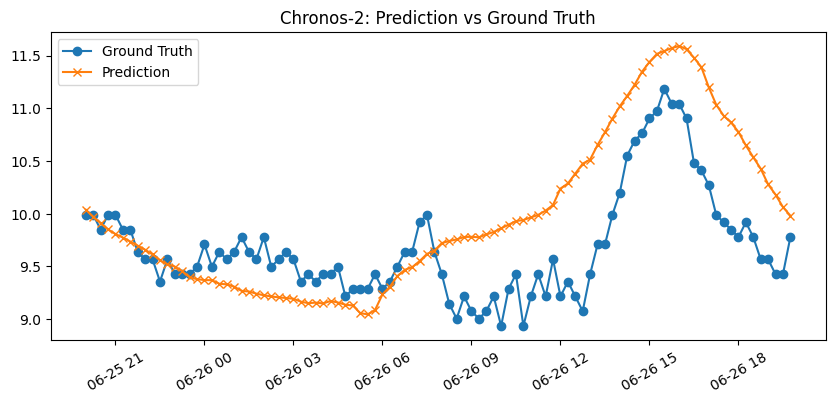

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(comparison["timestamp"], comparison["target"], label="Ground Truth", marker="o")
plt.plot(comparison["timestamp"], comparison["pred_median"], label="Prediction", marker="x")
plt.legend()
plt.title("Chronos-2: Prediction vs Ground Truth")
plt.xticks(rotation=30)
plt.show()
